In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Libraries
import os
import sys
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
#General libraries
import numpy as np
import scipy.io as sio
import time
import cv2
import os
import h5py
#Import JAX libraries
import jax
from jax import device_put
from jax import jit, grad, vmap, value_and_grad
from jax.config import config
import jax.numpy as jnp
import optax

#Plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from tqdm import tqdm
from typing import List, Dict,Tuple


# Auxiliary Functions

In [76]:
class Dataset:
    def __init__(self, data: np.ndarray) -> None:
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)
class DataLoader:
    def __init__(self, dataset: Dataset, batch_size: int, sample_function) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.sample_function = sample_function

    def __iter__(self):
        batch_idx_list = self.sample_function(self.dataset, self.batch_size)
        data = [self.dataset[batch_idx] for batch_idx in batch_idx_list]
        return iter(data)
    def __getitem__(self):
        batch_idx_list = self.sample_function(self.dataset, self.batch_size)
        data = [self.dataset[batch_idx] for batch_idx in batch_idx_list]

def get_batch(dataset: Dataset, batch_size: int):
    N = len(dataset)
    return np.split(
        np.arange(N),
        np.arange(batch_size, N, batch_size),
    )
    
def glorot_normal(in_dim, out_dim):
    glorot_stddev = np.sqrt(2.0 / (in_dim + out_dim))
    W = glorot_stddev * jnp.array(np.random.normal(size=(in_dim, out_dim)))
    return W

def init_params(layers):
    params = []
    in_dim, out_dim = layers[0], layers[1]
    U1=glorot_normal(in_dim, out_dim)
    b1=jnp.zeros(out_dim)
    U2=glorot_normal(in_dim, out_dim)
    b2=jnp.zeros(out_dim)
    for i in range(len(layers) - 1):
        in_dim, out_dim = layers[i], layers[i + 1]
        W = glorot_normal(in_dim, out_dim)
        b = jnp.zeros(out_dim)
        g = jnp.ones([out_dim])
        params.append({"W": W, "b": b,"g":g})
    return params


def FCN_WN(params,X_in,M1,M2,activation,norm_fn):
    H =  norm_fn(X_in,M1,M2)
    for idx in range(len(params)):
        layer=params[idx]
        W=layer["W"]
        b=layer["b"]
        g=layer["g"]
        #Weight Normalization:
        V = W/jnp.linalg.norm(W, axis = 0, keepdims=True)
        #Matrix multiplication
        H = jnp.matmul(H,V)
        #Add bias
        H=g*H+b
        if idx<len(params)-1:
            H = activation(H) 
    return H
def identity(X,X_min,X_max):
    return X

def MSE(pred,exact,weight=1):
    return jnp.mean(weight*jnp.square(pred - exact))

def MAE(pred,exact,weight=1):
    return jnp.mean(weight*jnp.abs(pred - exact))

def relative_error2(pred,exact):
    return np.linalg.norm(exact-pred,2)/np.linalg.norm(exact,2)

def save_list(Loss,path,name='loss-'):
    filename=path+name+".npy"
    np.save(filename, np.array(Loss))
    
def save_MLP_params(params: List[Dict[str, np.ndarray]], save_path):
    with h5py.File(save_path, "w") as f:
        for layer_idx, layer_params in enumerate(params):
            layer_group = f.create_group(f"Layer_{layer_idx/2.0:.2f}")
            W, b, g= layer_params.values()
            layer_group.create_dataset("W", shape=W.shape, dtype=np.float32, data=W)
            layer_group.create_dataset("b", shape=b.shape, dtype=np.float32, data=b)
            layer_group.create_dataset("g", shape=g.shape, dtype=np.float32, data=g)
            
def read_params(filename):
    data = h5py.File(filename, 'r')
    recover_params=[]
    for layer in data.keys() :
        stored={'W':data[layer]['W'][:],'b': data[layer]['b'][:],'g': data[layer]['g'][:]}
        recover_params.append(stored)
    return recover_params
def get_pdf(u_hist,bins=30):
    hist,bins=np.histogram(u_hist,bins=bins,density=True)
    prob_density=hist
    return prob_density,bins
def get_colors_plot(cmap='RdBu',n_colors=2):
    cmap = plt.get_cmap(cmap)
    colors = [cmap(i) for i in np.linspace(0, 1, n_colors)]
    return colors

def plotAIV3D(full_data,f_names,plot_type='mid_z',hor_size=3,window=4,cmap='RdBu_r',size=0.1,font_size='11',save_path=''):
    #Domain
    t_test, x_test, y_test, z_test  =full_data[:,0:1],full_data[:,1:2],full_data[:,2:3],full_data[:,3:4]
    tplot=t_test[0][0]
    midplane_x=0.5*(np.max(x_test)+np.min(x_test))
    midplane_y=0.5*(np.max(y_test)+np.min(y_test))
    midplane_z=0.5*(np.max(z_test)+np.min(z_test))
    if plot_type=='mid_y':
        idx_plot=np.argwhere(y_test>=midplane_y)[:,0]
    elif plot_type=='mid_x':
        idx_plot=np.argwhere(x_test<=midplane_x)[:,0]
    elif plot_type=='mid_z':
        idx_plot=np.argwhere(z_test<=midplane_z)[:,0]
    else:
        idx_plot=np.arange(len(y_test)) 
    #File name:
    image_name=save_path+f't={tplot:.3f}s-{plot_type}.png'
    #Functions
    F=full_data[:,full_data.shape[1]-len(f_names)+1:]
    #Compute velocity
    V_pred=np.sqrt(F[:,0]**2+F[:,1]**2+F[:,2]**2)[:,None]
    F=np.hstack((F,V_pred))
    F=F.T
    #Plot
    lower_lim=np.min(full_data[:,1:4],axis=0)
    upper_lim=np.max(full_data[:,1:4],axis=0)
    fig = plt.figure(figsize=(hor_size*len(F),window))
    plt.rcParams['font.size'] = font_size
    for i in range(len(F)):
        ax = fig.add_subplot(1, len(F), i+1, projection='3d')
        img = ax.scatter(x_test[idx_plot], y_test[idx_plot], z_test[idx_plot], c=F[i,idx_plot], cmap=cmap,s=size)
        fig.colorbar(img,fraction=0.046, pad=0.04)
        ax.set_title(f'{f_names[i]} at t={tplot:.3f}s')
        ax.set_xlim([lower_lim[0],upper_lim[0]])
        ax.set_ylim([lower_lim[1],upper_lim[1]])
        ax.set_zlim([lower_lim[2],upper_lim[2]])
        plt.axis('off')
    plt.savefig(image_name)

# Tunning Parameters

In [4]:
Run_type = '3D_NS_Part1'
Mode='RBA_100'
seed_np=1111

#Model Architecture
num_layer=8
width_layer = 200 # neurons/layer
layers = [4] + num_layer*[width_layer] + [4]
print('Model Architecture:')
print(layers)

#Global weights
lamD = 50
lamE = 1
lamB = 100

#learning 
num_epochs_adam = 2632
approx_sampler = get_batch 
res_sampler = get_batch 

lr0=2*10**(-3)
lrf=1.5*10**(-4)
decay_rate=0.9
decay_step=10000
batch_size= 52500
n_batches = 101

#RBA
lr_lambdas_0=2*10**(-1)
init_zero   = True
gamma=0.999
use_RBA=True
lam_min=1

#Training pOints
N_b = 5e5
N_f = 5e6

#Scaling NN output
u_scale=0.1
v_scale=1
w_scale=0.1
scale_p=100

#Data   
domain_index = 'M1_3Dgeometry1_domain1'
plane_index = 'pial1-0um'


dataset_name = f'{Mode},RBA_All:{use_RBA}_Seed:{seed_np}'

#Paths
data_path=project_root+"/Data/InverseNS.mat"
#Save path
save_path=project_root+"/ResultsNS/"
print(dataset_name)

Model Architecture:
[4, 200, 200, 200, 200, 200, 200, 200, 200, 4]
RBA_100,RBA_All:True_Seed:1111


## Initialize Model

In [5]:
activation_fn=jnp.sin
norm_fn    = identity
Norm_metric1=lambda x: 0
Norm_metric2=lambda x: 0  
Error_fn=MSE
np.random.seed(seed_np)
params = init_params(layers) 
pinn_fn = FCN_WN # Set FCN 
decay_step=num_epochs_adam*95*np.log(decay_rate)/np.log(lrf/lr0)
print(f'The decay step will be {decay_step}')
optimizer_w = optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate,))
opt_state_w = optimizer_w.init(params)
    

The decay step will be 10170.512017646875


## Create paths to save models and data

In [45]:
result_path = (
        save_path+f'{Run_type}/{dataset_name}/')
images_path = result_path+"Images/"
big_path = result_path+"Data/"

os.makedirs(result_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)
os.makedirs(big_path, exist_ok=True)

print("The save path is:",result_path)
print("The images path is:",images_path)
print("The big path is:",big_path)

The save path is: /users/jdtoscan/Documents/RBA_Paper_1/RBA_Jax/ResultsNS/3D_NS_Part1/RBA_100,RBA_All:True_Seed:1111/
The images path is: /users/jdtoscan/Documents/RBA_Paper_1/RBA_Jax/ResultsNS/3D_NS_Part1/RBA_100,RBA_All:True_Seed:1111/Images/
The big path is: /users/jdtoscan/Documents/RBA_Paper_1/RBA_Jax/ResultsNS/3D_NS_Part1/RBA_100,RBA_All:True_Seed:1111/Data/


## Load Data


In [7]:
All_data=sio.loadmat(data_path)
X_PIV_val=All_data['X_VAL']
V_PIV_val=All_data['V_VAL']
final_points=All_data['Train']
Re=0.015742801


In [8]:
X_BCs_raw=final_points[0][0]
X_data_raw=final_points[0][1]
X_res=final_points[0][2]
print(X_data_raw.shape,X_BCs_raw.shape,X_res.shape)
np.random.seed(seed_np)
idx_BCs_val=np.random.choice(np.arange(X_BCs_raw.shape[0]),size=20000,replace=False)
X_BCs_val=X_BCs_raw[idx_BCs_val,:]
print(X_BCs_val.shape)

(9405, 6) (534375, 7) (4987500, 4)
(20000, 7)


# Normalizing Functions

In [9]:
lower_bound, upper_bound = np.min(X_BCs_raw[:, :4]), np.max(X_BCs_raw[:, :4])
print(lower_bound,upper_bound)
normalize = lambda x: 2 * (x - lower_bound) / (upper_bound - lower_bound)-1 
unnormalize= lambda x: (x+1)*(upper_bound-lower_bound)/2+lower_bound 
lower_bound2, upper_bound2 = np.min(X_data_raw[:, 4:]), np.max(X_data_raw[:, 4:])
print(lower_bound2,upper_bound2)
normalize2 = lambda x: 2 * (x - lower_bound2) / (upper_bound2 - lower_bound2)-1 
unnormalize2 = lambda x: (x+1)*(upper_bound2-lower_bound2)/2+lower_bound2 

0.0 1.5555555820465088
-0.9643359 0.4315001


# Final Data Details

In [10]:
X_approx = np.hstack((normalize(X_data_raw[:, :4]), X_data_raw[:, 4:]))
X_BCs    = np.hstack((normalize(X_BCs_raw[:, :4]),  X_BCs_raw[:, 4:]))
X_res     =normalize(X_res)
dataset_bcs,dataset_approx, dataset_res = Dataset(X_BCs),Dataset(X_approx), Dataset(X_res)
print(f'Bounds for Normalized PIV Data with {X_approx.shape} points:')
print(np.min(X_approx,axis=0))
print(np.max(X_approx,axis=0))
print(f'Bounds for Normalized BCs Data with {X_BCs.shape} points:')
print(np.min(X_BCs,axis=0))
print(np.max(X_BCs,axis=0))
print(f'Bounds for Normalized Residual Data with {X_res.shape} points:')
print(np.min(X_res,axis=0))
print(np.max(X_res,axis=0))


Bounds for Normalized PIV Data with (9405, 6) points:
[-0.99944985 -0.5551648  -0.98515797 -0.48571432 -0.1854088  -0.9643359 ]
[ 0.26445687  0.6540284   0.99981666 -0.4571429   0.34859857  0.4315001 ]
Bounds for Normalized BCs Data with (534375, 7) points:
[-1.         -0.56428573 -0.98571429 -0.75        0.          0.
  0.        ]
[0.26486821 0.69285719 1.         0.36428567 0.         0.
 0.        ]
Bounds for Normalized Residual Data with (4987500, 4) points:
[-1.         -0.56428573 -0.98571429 -0.75      ]
[0.26486821 0.69285719 1.         0.36097785]


## Define batches and iterations

In [11]:
batS=52500
N_BC=len(X_BCs)
N_Res=len(X_res)
N_data=len(X_approx)
N_train=int(np.max([N_BC,N_Res,N_data]))
All_its=int(N_train/batS)
batch_size_Res=int(np.ceil(N_Res/All_its))
batch_size_BCs=int(np.ceil(N_BC/All_its))
batch_size_data=int(np.ceil(N_data/All_its))
print(f'There will be {All_its} steps per Epoch. So:')
print(f'Batch size for residual points: {batch_size_Res}, Batch size for BCs: {batch_size_BCs}, Batch size for data: {batch_size_data}')
# Modify dataset to analize the data at every iteration
X_approx=np.tile(X_approx,(All_its,1))
dataset_approx = Dataset(X_approx)
N_BC=len(X_BCs)
N_Res=len(X_res)
N_data=len(X_approx)
N_train=int(np.max([N_BC,N_Res,N_data]))
All_its=int(N_train/batS)
batch_size_Res=int(np.ceil(N_Res/All_its))
batch_size_BCs=int(np.ceil(N_BC/All_its))
batch_size_data=int(np.ceil(N_data/All_its))
print(f'There will be {All_its} steps per Epoch. So:')
print(f'Batch size for residual points: {batch_size_Res}, Batch size for BCs: {batch_size_BCs}, Batch size for data: {batch_size_data}')

There will be 95 steps per Epoch. So:
Batch size for residual points: 52500, Batch size for BCs: 5625, Batch size for data: 99
There will be 95 steps per Epoch. So:
Batch size for residual points: 52500, Batch size for BCs: 5625, Batch size for data: 9405


In [12]:
data_approx = DataLoader(dataset_approx, 
                         batch_size=batch_size_data, 
                         sample_function=approx_sampler)
data_res    = DataLoader(dataset_res, 
                         batch_size=batch_size_Res,
                         sample_function=res_sampler)
data_BCs    = DataLoader(dataset_bcs, 
                         batch_size=batch_size_BCs,
                         sample_function=res_sampler)

# RBA Weights

In [13]:
np.random.seed(seed_np)
lambda_piv=np.random.uniform(0,1,2*batch_size_data).reshape(batch_size_data,2)
np.random.seed(seed_np)
lambda_bcs=np.random.uniform(0,1,3*batch_size_BCs).reshape(batch_size_BCs,3)
np.random.seed(seed_np)
lambda_res=np.random.uniform(0,1,4*batch_size_Res).reshape(batch_size_Res,4)

if init_zero:
    lambda_piv=lambda_piv*0
    lambda_bcs=lambda_bcs*0
    lambda_res=lambda_res*0
    print('Zero Initialization for lambdas')
print(f'The shape of the lambdas for PIV, BCs and Residual points are {lambda_piv.shape},{lambda_bcs.shape},{lambda_res.shape}')
lambdas={'BCs':lambda_bcs,
         'Data':lambda_piv,
         'Res':lambda_res}

Zero Initialization for lambdas
The shape of the lambdas for PIV, BCs and Residual points are (9405, 2),(5625, 3),(52500, 4)


# Model

In [14]:
M1= Norm_metric1(X_res[:, :4])
M2= Norm_metric2(X_res[:, :4])
def u_PINN(params):
    fn = lambda x: pinn_fn(params, x, M1, M2,activation_fn,norm_fn)
    u, v, w, p = lambda x: u_scale*fn(x)[0], lambda x: v_scale*fn(x)[1],lambda x: w_scale*fn(x)[2], lambda x: scale_p*fn(x)[3]
    return u, v, w, p  
u_model=u_PINN   

# Loss Functions

In [15]:
nu=1/Re
p_scale=100
def NS_equation(params):
    """
    input  = (t, x, y, z)
    output = (u, v, w, p)
    e_1=u_t+(u*u_x+v*u_y+w*u_z)- nu (u_xx+u_yy)+ w_zz)+ p_x
    e_2=v_t+(u*v_x+v*v_y+w*v_z)- nu (v_xx+v_yy)+ v_zz)+ p_y
    e_3=w_t+(u*w_x+v*w_y+w*w_z)- nu (w_xx+w_yy)+ w_zz)+ p_z
    e_4=u_x+u_y+w_z
    """
    
    fn = lambda x: pinn_fn(params, x,M1,M2,activation_fn,norm_fn) 
    u, v, w, p = lambda x: u_scale*fn(x)[0], lambda x: v_scale*fn(x)[1],lambda x: w_scale*fn(x)[2], lambda x: scale_p*fn(x)[3]
    # derivatives

    u_t,  v_t,  w_t  = lambda x: grad(u)(x)[0],   lambda x: grad(v)(x)[0],   lambda x: grad(w)(x)[0]
    u_x,  u_y,  u_z  = lambda x: grad(u)(x)[1],   lambda x: grad(u)(x)[2],   lambda x: grad(u)(x)[3]
    v_x,  v_y,  v_z  = lambda x: grad(v)(x)[1],   lambda x: grad(v)(x)[2],   lambda x: grad(v)(x)[3]
    w_x,  w_y,  w_z  = lambda x: grad(w)(x)[1],   lambda x: grad(w)(x)[2],   lambda x: grad(w)(x)[3]
    p_x,  p_y,  p_z  = lambda x: grad(p)(x)[1],   lambda x: grad(p)(x)[2],   lambda x: grad(p)(x)[3]
    u_xx, u_yy, u_zz = lambda x: grad(u_x)(x)[1], lambda x: grad(u_y)(x)[2], lambda x: grad(u_z)(x)[3]
    v_xx, v_yy, v_zz = lambda x: grad(v_x)(x)[1], lambda x: grad(v_y)(x)[2], lambda x: grad(v_z)(x)[3]
    w_xx, w_yy, w_zz = lambda x: grad(w_x)(x)[1], lambda x: grad(w_y)(x)[2], lambda x: grad(w_z)(x)[3]
    # equations
    eq1 = (
        lambda x: (u_t(x)
        + (u(x) * u_x(x) + v(x) * u_y(x) + w(x) * u_z(x))
        + p_x(x)*p_scale
        - nu * (u_xx(x) + u_yy(x) + u_zz(x)))/p_scale
    )
    eq2 = (
        lambda x: (v_t(x)
        + (u(x) * v_x(x) + v(x) * v_y(x) + w(x) * v_z(x))
        + p_y(x)*p_scale
        - nu * (v_xx(x) + v_yy(x) + v_zz(x)))/p_scale
    )
    eq3 = (
        lambda x:(w_t(x)
        + (u(x) * w_x(x) + v(x) * w_y(x) + w(x) * w_z(x))
        + p_z(x)*p_scale
        - nu * (w_xx(x) + w_yy(x) + w_zz(x)))/p_scale
    )  
    eq4 = lambda x: u_x(x) + v_y(x) + w_z(x)
    
    return eq1, eq2, eq3, eq4

In [16]:
# For Adam Optimizeraa
@jit
def update(params, 
           lambdas,
           opt_state_w, 
           data: Tuple[np.ndarray, np.ndarray, np.ndarray]):
    X_res, X_approx, X_BCs = data
    txyz, u_data,v_data    = X_approx[:, :4], X_approx[:, 4:5],X_approx[:, 5:6]
    txyz_bcs     = X_BCs[:, :4]
    # Models
    eq1, eq2,eq3,eq4    = NS_equation(params)
    u_fx,v_fx,w_fx,p_fx = u_model(params)
    # Evaluate models
    u_pred  = vmap(u_fx, (0))(txyz)[:,None]
    v_pred  = vmap(v_fx, (0))(txyz)[:,None]
    u_pred_bcs  = vmap(u_fx, (0))(txyz_bcs)[:,None]
    v_pred_bcs  = vmap(v_fx, (0))(txyz_bcs)[:,None]
    w_pred_bcs  = vmap(w_fx, (0))(txyz_bcs)[:,None]
    # Compute residuals
    eqn_momentum_x      = vmap(eq1, (0))(X_res)[:,None]
    eqn_momentum_y      = vmap(eq2, (0))(X_res)[:,None]
    eqn_momentum_z      = vmap(eq3, (0))(X_res)[:,None]
    eqn_mass            = vmap(eq4, (0))(X_res)[:,None]
   # Compute residuals
    e_u     =jnp.abs(u_pred-u_data)
    e_v     =jnp.abs(v_pred-v_data)
    e_data  =jnp.hstack((e_u,e_v)) 
    e_bcs   = jnp.abs(jnp.hstack((u_pred_bcs,v_pred_bcs,w_pred_bcs)))
    e_NS     = jnp.abs(jnp.hstack((eqn_momentum_x,eqn_momentum_y,eqn_momentum_z,eqn_mass)))
    #Update RBA_Weights NS
    lambdas['Data']= (gamma)*lambdas['Data'] +lr_lambdas_0*e_data/jnp.max(e_data,axis=0)
    lambdas['BCs']=  (gamma)*lambdas['BCs']   +lr_lambdas_0*e_bcs/jnp.max(e_bcs,axis=0)/10    
    lambdas['Res'] = (gamma)*lambdas['Res']  +lr_lambdas_0*e_NS/jnp.max(e_NS,axis=0)  
    
    def loss_fn(params):
        # Models
        eq1, eq2,eq3,eq4    = NS_equation(params)
        u_fx,v_fx,w_fx,p_fx = u_model(params)
        # residuals
        eqn_momentum_x      = vmap(eq1, (0))(X_res)[:,None]
        eqn_momentum_y      = vmap(eq2, (0))(X_res)[:,None]
        eqn_momentum_z      = vmap(eq3, (0))(X_res)[:,None]
        eqn_mass            = vmap(eq4, (0))(X_res)[:,None]
        e_NS     = jnp.abs(jnp.hstack((eqn_momentum_x,eqn_momentum_y,eqn_momentum_z,3.16*eqn_mass)))


        # approximation error BCs
        txyz_bcs     = X_BCs[:, :4]
        u_pred_bcs  = vmap(u_fx, (0))(txyz_bcs)[:,None]
        v_pred_bcs  = vmap(v_fx, (0))(txyz_bcs)[:,None]
        w_pred_bcs  = vmap(w_fx, (0))(txyz_bcs)[:,None]
        e_bcs       = jnp.hstack((u_pred_bcs,v_pred_bcs,w_pred_bcs))
        # approximation error Data
        txyz, u_data,v_data    = X_approx[:, :4], X_approx[:, 4:5],X_approx[:, 5:6]
        u_pred  = vmap(u_fx, (0))(txyz)[:,None]
        v_pred  = vmap(v_fx, (0))(txyz)[:,None]

        #Compute Data residuals
        e_u=jnp.abs(u_pred-u_data)
        e_v=jnp.abs(v_pred-v_data)

        # Select Weights
        lamB_it=1*lambdas['BCs'] + lam_min
        lamD_it=1*lambdas['Data']+ lam_min
        lamE_it=1*lambdas['Res'] + lam_min

        #Loss Equation
        loss_NS             = lamE*Error_fn(e_NS,0.0 ,weight=lamE_it)

        #Loss Data
        loss_approx_u       = lamD*Error_fn(e_u        ,0.0   ,weight=lamD_it[:,0:1])
        loss_approx_v       = lamD/10*Error_fn(e_v     ,0.0   ,weight=lamD_it[:,1:2])
        #Loss BCs
        loss_BCs            = lamB*Error_fn(e_bcs  ,0.0   ,weight=lamB_it)

        #Total Loss
        loss                = (        
                              + loss_BCs
                              + loss_approx_v
                              + loss_approx_u
                              + loss_NS
                              )
        return loss, (
                        (loss,
                        Error_fn(u_pred_bcs  ,0.0   ,weight=1),
                        Error_fn(v_pred_bcs  ,0.0   ,weight=1),
                        Error_fn(w_pred_bcs  ,0.0   ,weight=1),
                        Error_fn(v_pred  ,v_data   ,weight=1),
                        Error_fn(u_pred  ,u_data   ,weight=1),
                        Error_fn(eqn_momentum_x  ,0.0   ,weight=1), 
                        Error_fn(eqn_momentum_y  ,0.0   ,weight=1),
                        Error_fn(eqn_momentum_z  ,0.0   ,weight=1),
                        Error_fn(eqn_mass  ,0.0   ,weight=1)),
                        lambdas)

    grad_fn = value_and_grad(loss_fn, has_aux=True)
    #Update weights
    (_, aux_vals),all_grads=grad_fn(params)
    losses,lambdas         =aux_vals
    grad_w               =all_grads
    updates, opt_state_w = optimizer_w.update(grad_w, opt_state_w, params)
    params  = optax.apply_updates(params, updates)
    return params, lambdas, opt_state_w, losses,grad_w

# Training 


In [17]:
# %% train model
def train_epoch(params, 
                lambdas,
                opt_state_w, 
                data: Tuple[DataLoader, DataLoader, DataLoader]):
    dataloader_res,dataloader_approx,dataloader_BCs = data
    epoch_losses = []
    grads_all_batches = []
    i=0
    for ((_, X_res_batch),
    (_, X_approx_batch),
    (_, X_BCs_batch)) in zip(
        enumerate(dataloader_res),
        enumerate(dataloader_approx),
        enumerate(dataloader_BCs)
    ):
        # train for a batch
        batch_data = (X_res_batch,
                      X_approx_batch,
                      X_BCs_batch)
        params, lambdas, opt_state_w, batch_losses,grad_test= update(
        params, lambdas, opt_state_w, batch_data)
        j=0
        #Process Network gradients for Bottleneck Theory
        for name, param in enumerate(grad_test):
            grads=jax.device_get(param['W'])
            if i==0:
                grads_all_batches.append(grads)
            else:
                grads_all_batches[j] = np.dstack((grads_all_batches[j], grads))
            j+=1
        i=i+1
    m = [np.mean(arr, axis=2) for arr in grads_all_batches]  # get list of means
    s = [np.std(arr, axis=2) for arr in grads_all_batches]  # get list of stds
    #Store data 
    epoch_losses.append(batch_losses)
    loss_avg: np.ndarray = np.mean(np.array(jax.device_get(epoch_losses)), axis=0)
    return (params, 
            lambdas,
            opt_state_w, 
            loss_avg,)

In [18]:
#Initialize Containers for results
log_loss      = []
log_epoch     = []
log_lambdas   = []
log_error_u   = []
log_error_v   = []
log_error_u_bcs= []
log_error_v_bcs= []
log_error_w_bcs= []
#Initialize containersfor IBT
Mu=np.zeros((1,len(layers)-1))
Sigmas=np.zeros((1,len(layers)-1))
Norm=np.zeros((1,len(layers)-1))
#Times
starting_epoch=0
nu_v=1/Re
start_time2 = time.time()
start_time = time.time()
start_time2 = time.time()
for epoch in range(starting_epoch, num_epochs_adam + 1):
    # train epoch and obtain IB parameters
    params, lambdas, opt_state_w, loss_avg  = train_epoch(
    params, lambdas, opt_state_w, (data_res, 
                                                    data_approx, 
                                                    data_BCs))
    #Compute learning rate
    optim_step =  epoch * int(np.ceil(N_train / batS))
    lr = lr0 * decay_rate ** (optim_step / decay_step)
    #Compute Validation Error Data
    u_fx,v_fx,w_fx,_= u_model(params)     
    u_pred = vmap(u_fx, (0))(normalize(X_PIV_val[:,:4]))[:,None]
    v_pred = vmap(v_fx, (0))(normalize(X_PIV_val[:,:4]))[:,None]
    u_piv=V_PIV_val[:,0:1]
    v_piv=V_PIV_val[:,1:2]
    Error_u = jax.device_get(relative_error2(u_pred,u_piv))
    Error_v = jax.device_get(relative_error2(v_pred,v_piv))
    #Compute Validation Error BCS
    u_bcs = vmap(u_fx, (0))(normalize(X_BCs_val[:,:4]))[:,None]
    v_bcs = vmap(v_fx, (0))(normalize(X_BCs_val[:,:4]))[:,None]
    w_bcs = vmap(w_fx, (0))(normalize(X_BCs_val[:,:4]))[:,None]
    Error_u_bcs =  jax.device_get(MAE(u_bcs,0.0))
    Error_v_bcs  = jax.device_get(MAE(v_bcs,0.0))
    Error_w_bcs  = jax.device_get(MAE(w_bcs,0.0))
    # Store Epoch Results  
    log_error_u.append(Error_u)
    log_error_v.append(Error_v)
    log_error_u_bcs.append(Error_u_bcs)
    log_error_v_bcs.append(Error_v_bcs)
    log_error_w_bcs.append(Error_w_bcs)     
    log_lambdas.append(jax.device_get(lambdas))
    log_loss.append(loss_avg)
    (
                        loss,
                        loss_BCs_u,
                        loss_BCs_v,
                        loss_BCs_w,
                        loss_approx_v,
                        loss_approx_u,
                        loss_eqn_momentum_x,
                        loss_eqn_momentum_y,
                        loss_eqn_momentum_z,
                        loss_eqn_mass,
    ) = loss_avg
    log_epoch.append(epoch)
    end_time = time.time()
    loss_NS =(loss_eqn_momentum_x + 
              loss_eqn_momentum_y +
              loss_eqn_momentum_z +
              loss_eqn_mass)
    Error    =(loss_BCs_u
              +loss_BCs_v
              +loss_BCs_w
              +loss_approx_v
              +loss_approx_u)
    lambda_res_print_max=np.max(lambdas['Res'])
    lambda_res_print_min=np.min(lambdas['Res'])
    lambda_res_print_mean=np.mean(lambdas['Res'])

    lambda_data_print_max=np.max(lambdas['Data'])
    lambda_data_print_min=np.min(lambdas['Data'])
    lambda_data_print_mean=np.mean(lambdas['Data'])

    lambda_bcs_print_max=np.max(lambdas['BCs'])
    lambda_bcs_print_min=np.min(lambdas['BCs'])
    lambda_bcs_print_mean=np.mean(lambdas['BCs'])

    print("-" * 50)
    print(
    f"Epoch: {epoch:d}, It: {optim_step:d},Total Loss: {loss:.3e}, Time: {end_time-start_time:.2f}s, Learning Rate: {lr:.2e}")
    print(
    f"Epoch: {epoch:d}, Test:  RL2 u: {Error_u:.3e}, RL2 v: {Error_v:.3e}")
    print(
    f"Epoch: {epoch:d}, Train: L2 u: {loss_approx_u:.3e}, L2 v: {loss_approx_v:.3e}")
    print(
    f"Epoch: {epoch:d}, Test:  MAE u_BCs: {Error_u_bcs:.3e}, MAE v_BCs: {Error_v_bcs:.3e}, MAE w_BCs: {Error_w_bcs:.3e}")
    print(
    f"Epoch: {epoch:d}, Train: L2 u_BCs: {loss_BCs_u:.3e}, L2 v_BCs: {loss_BCs_v:.3e}, L2 w_BCs: {loss_BCs_w:.3e}")
    print(
    f"Epoch: {epoch:d}, L2 M_x: {loss_eqn_momentum_x:.3e},  L2 M_y: {loss_eqn_momentum_y:.3e}, L2 M_z: {loss_eqn_momentum_z:.3e},  L2 Mass: {loss_eqn_mass:.3e}")
    print(
    f"Epoch: {epoch:d}, Lambda PDE (Max): {lambda_res_print_max:.3e},Lambda PDE (Min): {lambda_res_print_min:.3e}, Lambda PDE (Mean): {lambda_res_print_mean:.3e}")
    print(
    f"Epoch: {epoch:d}, Lambda Data (Max): {lambda_data_print_max:.3e},Lambda Data (Min): {lambda_data_print_min:.3e}, Lambda Data (Mean): {lambda_data_print_mean:.3e}")
    print(
    f"Epoch: {epoch:d}, Lambda BCS (Max): {lambda_bcs_print_max:.3e},Lambda BCS (Min): {lambda_bcs_print_min:.3e}, Lambda BCS (Mean): {lambda_bcs_print_mean:.3e}")
    start_time = time.time()
    # Save checkpoint and latest
    
    if epoch %  num_epochs_adam//10 == 0 or epoch == num_epochs_adam:
        output_path = result_path +f"params.h5"
        save_list(log_loss,result_path,f'Loss')
        save_list(log_lambdas,result_path,f'Lambdas')
        save_MLP_params(params, output_path)   
end_time2 = time.time()

--------------------------------------------------
Epoch: 0, It: 0,Total Loss: 4.462e+00, Time: 119.02s, Learning Rate: 2.00e-03
Epoch: 0, Test:  RL2 u: 9.889e-01, RL2 v: 7.897e-01
Epoch: 0, Train: L2 u: 2.298e-03, L2 v: 4.442e-02
Epoch: 0, Test:  MAE u_BCs: 6.778e-03, MAE v_BCs: 6.584e-02, MAE w_BCs: 6.029e-03
Epoch: 0, Train: L2 u_BCs: 8.373e-05, L2 v_BCs: 8.010e-03, L2 w_BCs: 5.620e-05
Epoch: 0, L2 M_x: 4.189e-01,  L2 M_y: 2.855e-01, L2 M_z: 3.454e-01,  L2 Mass: 5.860e-03
Epoch: 0, Lambda PDE (Max): 1.210e+01,Lambda PDE (Min): 3.681e-01, Lambda PDE (Mean): 2.421e+00
Epoch: 0, Lambda Data (Max): 1.813e+01,Lambda Data (Min): 2.646e-01, Lambda Data (Mean): 2.888e+00
Epoch: 0, Lambda BCS (Max): 1.485e+00,Lambda BCS (Min): 1.245e-01, Lambda BCS (Mean): 4.800e-01
--------------------------------------------------
Epoch: 1, It: 95,Total Loss: 3.934e+01, Time: 30.54s, Learning Rate: 2.00e-03
Epoch: 1, Test:  RL2 u: 9.543e-01, RL2 v: 8.311e-01
Epoch: 1, Train: L2 u: 2.144e-03, L2 v: 4.822e-0

## Losses and Errors

In [47]:
end_time2 = time.time()
print(f"Total training time:{(end_time2-start_time2)/3600:.2f}h")

Total training time:27.00h


In [20]:
name_Errors=big_path+'-Errors.mat'
Final_Errors={"u":log_error_u,
              "v":log_error_v,
              "u_bcs":log_error_u_bcs,
              "v_bcs":log_error_v_bcs,
              "w_bcs":log_error_w_bcs,
              "loss":log_loss,}
sio.savemat(name_Errors, Final_Errors)
print(name_Errors)

/users/jdtoscan/Documents/RBA_Paper_1/RBA_Jax/ResultsNS/3D_NS_Part1/RBA_100,RBA_All:True_Seed:1111/Data/-Errors.mat


In [21]:
u_fx,v_fx,_,_= u_model(params)     
u_pred = vmap(u_fx, (0))(normalize(X_data_raw[:,:4]))[:,None]
v_pred = vmap(v_fx, (0))(normalize(X_data_raw[:,:4]))[:,None]
u_piv=X_data_raw[:,4:5]
v_piv=X_data_raw[:,5:6]
Error_u = jax.device_get(relative_error2(u_pred,u_piv))
Error_v = jax.device_get(relative_error2(v_pred,v_piv))
print(f'Final Relative Error for u (PIV Data): {Error_u:.3e}')
print(f'Final Relative Error for v (PIV Data): {Error_v:.3e}')

Final Relative Error for u (PIV Data): 1.799e-01
Final Relative Error for v (PIV Data): 1.873e-01


In [23]:
#Recover units
delta_t = 1/29.16       # time interval between 2 snapshots - s
delta_x = 0.648e-6      # space interval between 2 pixel - m
delta_z = 0.648e-6
unit_x = delta_x       # space unit - 1 pixel = unit_x m
unit_z = delta_z        # space unit - 1 pixel = unit_z m
unit_u = delta_x/delta_t # velocity unit - 1 ppf = unit_u m/s
p_scale=100
# Parameters used for non-dimensionalization
L_char = 90*unit_x          # meter (90 pixel)
U_char = 10*unit_u          # m/s  (10 pixel/frame)
T_char = L_char / U_char   
nu_e=7*10**(-7)
rho=993
ums=10**6
L_char=L_char*ums
U_char=U_char*ums
rec_fact=np.array([T_char,L_char,L_char,L_char,U_char,U_char,U_char,(U_char/ums)**2*rho*p_scale])
rec_fact=rec_fact.reshape(1,len(rec_fact))

In [24]:
u_fx,v_fx,_,_= u_model(params)     
u_pred =  U_char*vmap(u_fx, (0))(normalize(X_PIV_val[:,:4]))[:,None]
v_pred =  U_char*vmap(v_fx, (0))(normalize(X_PIV_val[:,:4]))[:,None]
u_piv= U_char*V_PIV_val[:,0:1]
v_piv= U_char*V_PIV_val[:,1:2]
Error_u = jax.device_get(relative_error2(u_pred,u_piv))
Error_v = jax.device_get(relative_error2(v_pred,v_piv))
print(f'Final Relative Error for u (PIV Validation Data): {Error_u:.3e}')
print(f'Final Relative Error for v (PIV Validation Data): {Error_v:.3e}')

Final Relative Error for u (PIV Validation Data): 2.455e-01
Final Relative Error for v (PIV Validation Data): 2.047e-01


## Generate Histogram

In [25]:
u_piv_hist = np.array(jax.device_get(u_piv)).reshape(-1)
u_aiv_hist = np.array(jax.device_get(u_pred)).reshape(-1)
v_piv_hist = np.array(jax.device_get(v_piv)).reshape(-1)
v_aiv_hist = np.array(jax.device_get(v_pred)).reshape(-1)
bins=20
prob_density_u_piv,bins_u_piv=get_pdf(u_piv_hist,bins=bins)
prob_density_v_piv,bins_v_piv=get_pdf(v_piv_hist,bins=bins)
prob_density_u_aiv,bins_u_aiv=get_pdf(u_aiv_hist,bins=bins)
prob_density_v_aiv,bins_v_aiv=get_pdf(v_aiv_hist,bins=bins)

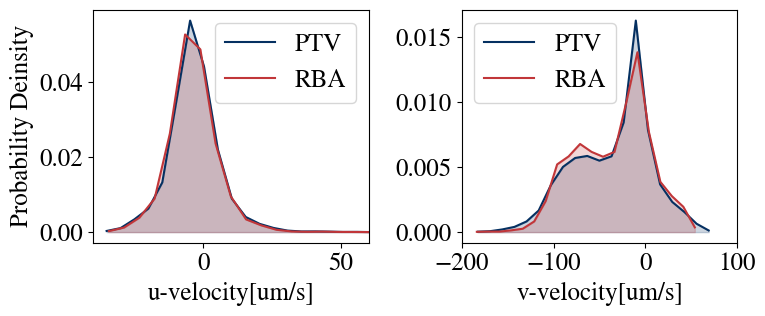

In [27]:
colors=get_colors_plot(cmap='RdBu_r', n_colors=8)
label=['RBA','PIV']
fig, axs = plt.subplots(1,2,figsize=(8,3.5))
plt.rcParams['font.size'] = '18'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

axs[0].plot(bins_u_piv[:-1],prob_density_u_piv,color=colors[0],label='PTV')
axs[0].fill_between(bins_u_piv[:-1],prob_density_u_piv,color=colors[0],alpha=0.2)
axs[0].plot(bins_u_aiv[:-1],prob_density_u_aiv,color=colors[-2],label='RBA')
axs[0].fill_between(bins_u_aiv[:-1],prob_density_u_aiv,color=colors[-2],alpha=0.2)
axs[0].set_ylabel('Probability Deinsity')
axs[0].set_xlabel('u-velocity[um/s]')
axs[0].set_xlim(-40,60)
axs[0].legend(loc='upper right')
axs[1].plot(bins_v_piv[:-1],prob_density_v_piv,color=colors[0],label='PTV')
axs[1].fill_between(bins_v_piv[:-1],prob_density_v_piv,color=colors[0],alpha=0.2)
axs[1].plot(bins_v_aiv[:-1],prob_density_v_aiv,color=colors[-2],label='RBA')
axs[1].fill_between(bins_v_aiv[:-1],prob_density_v_aiv,color=colors[-2],alpha=0.2)
axs[1].set_xlabel('v-velocity[um/s]')
axs[1].legend(loc='upper left')
axs[1].set_xlim(-200,100)

fig.tight_layout()
plt.savefig(images_path+f'/AIV-Prob_dist-lamb:{lamB,lamD,lamE},epochs:{num_epochs_adam}.png')
plt.show()

100%|██████████| 2633/2633 [00:00<00:00, 5109.09it/s]


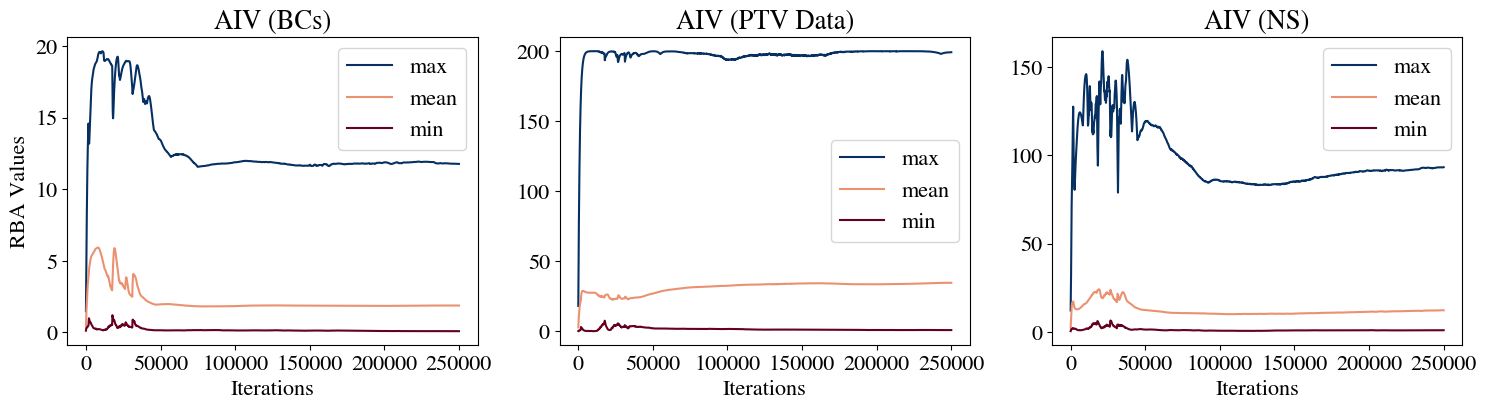

/users/jdtoscan/Documents/RBA_Paper_1/RBA_Jax/ResultsNS/3D_NS_Part1/RBA_100,RBA_All:True_Seed:1111/Data/-ALL_lambdas_history-Res.mat


In [29]:
n_colors=3+5
cmap = 'RdBu'
cmap = plt.get_cmap(cmap)
colors=get_colors_plot(cmap='RdBu_r',n_colors=12)
lambda_res_min=[]
lambda_res_max=[]
lambda_res_mean=[]
lambda_data_min=[]
lambda_data_max=[]
lambda_data_mean=[]
lambda_bcs_min=[]
lambda_bcs_max=[]
lambda_bcs_mean=[]
for i in tqdm(range(len(log_lambdas))):
    lambda_res_min.append(np.min(log_lambdas[i]['Res']))
    lambda_res_max.append(np.max(log_lambdas[i]['Res']))
    lambda_res_mean.append(np.mean(log_lambdas[i]['Res']))
    lambda_data_min.append(np.min(log_lambdas[i]['Data']))
    lambda_data_max.append(np.max(log_lambdas[i]['Data']))
    lambda_data_mean.append(np.mean(log_lambdas[i]['Data']))
    lambda_bcs_min.append(np.min(log_lambdas[i]['BCs']))
    lambda_bcs_max.append(np.max(log_lambdas[i]['BCs']))
    lambda_bcs_mean.append(np.mean(log_lambdas[i]['BCs']))
# plt.close()
figsize=(18,4)
fig = plt.figure(figsize=figsize)
plt.rcParams['font.size'] = '16'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
# add main title
ax = fig.add_subplot(1, 3, 1)
ax.plot(np.arange(len(lambda_res_max))*95, (lambda_bcs_max), color=colors[0], label = f'max')
ax.plot(np.arange(len(lambda_res_mean))*95,(lambda_bcs_mean), color=colors[-4], label = f'mean')
ax.plot(np.arange(len(lambda_res_max))*95, (lambda_bcs_min), color=colors[-1], label = f'min')
ax.set_xlabel('Iterations')#,fontsize='14')
ax.set_ylabel('RBA Values')#,fontsize='14')
ax.set_title('AIV (BCs)')
ax.legend()#(fontsize='12')
ax = fig.add_subplot(1, 3, 2)
ax.set_title('AIV (PTV Data)')
ax.plot(np.arange(len(lambda_res_max))*95, (lambda_data_max), color=colors[0], label = f'max')
ax.plot(np.arange(len(lambda_res_mean))*95,(lambda_data_mean), color=colors[-4], label = f'mean')
ax.plot(np.arange(len(lambda_res_max))*95, (lambda_data_min), color=colors[-1], label = f'min')
ax.set_xlabel('Iterations')#,fontsize='14')
ax.legend()#(fontsize='12')
ax = fig.add_subplot(1, 3,3)
ax.set_title('AIV (NS)')
ax.plot(np.arange(len(lambda_res_max))*95, (lambda_res_max), color=colors[0], label = f'max')
ax.plot(np.arange(len(lambda_res_mean))*95,(lambda_res_mean), color=colors[-4], label = f'mean')
ax.plot(np.arange(len(lambda_res_max))*95, (lambda_res_min), color=colors[-1], label = f'min')
ax.set_xlabel('Iterations')#,fontsize='14')
ax.legend()#(fontsize='12')
plt.savefig(result_path+f'/Mean-lamb-Res.png',dpi=500)
plt.show()


lambda_res_min=np.array(jax.device_get(lambda_res_min))
lambda_res_max=np.array(jax.device_get(lambda_res_max))
lambda_res_mean=np.array(jax.device_get(lambda_res_mean))
name_lambdas_hist=big_path+'-ALL_lambdas_history-Res.mat'
Final_lambdas={"min_res":lambda_res_min,
              "max_res":lambda_res_max,
              "mean_res":lambda_res_mean,
              "min_data":lambda_data_min,
              "max_data":lambda_data_max,
              "mean_data":lambda_data_mean,
              "min_bcs":lambda_bcs_min,
              "max_bcs":lambda_bcs_max,
              "mean_bcs":lambda_bcs_mean,
              }
sio.savemat(name_lambdas_hist, Final_lambdas)
print(name_lambdas_hist)


# Evaluate Model

Now we have a continous function so we input any value inside our domain. Thus lets plot 1000000 points at a given test time.

In [72]:
X_txyz=final_points[0][2]
spatial_points = X_txyz[:, 1:]  # Exclude the first column (time)
unique_points, indices = np.unique(spatial_points, axis=0, return_index=True)# Find unique rows (unique points) in the spatial dimensions
print(f'Unique points: {unique_points.shape}')

Unique points: (1760245, 3)


Choose any time inside the analized domain of interest

$$t\in [0,0.308]s$$

for instance let  t=0.15s

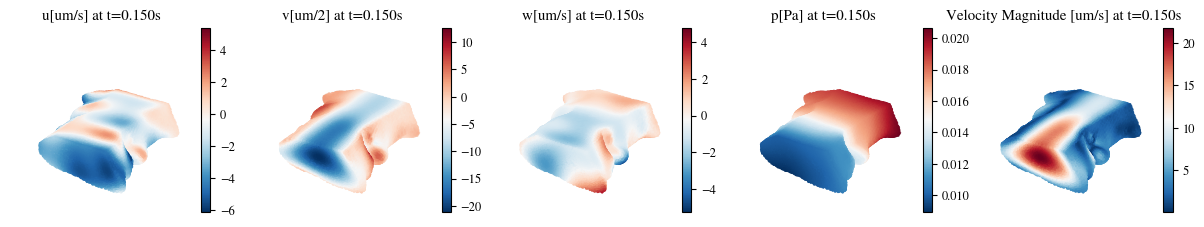

In [80]:
num_points=1000000
idx_plot=np.random.choice(np.arange(len(unique_points)),size=num_points,replace=False)
X_test=unique_points[idx_plot,:]
#Select points at t=t_frame
t_analize=0.15
t_analize=t_analize/T_char #Non-Dimensionalize our time
# Group Points and set the time
X_test=np.hstack((X_test[:,0:1]*0+t_analize,X_test))
# Normalize
X_test=normalize(X_test)
# Predictions
u_fx,v_fx,w_fx,p_fx = u_model(params)
u_pred  = vmap(u_fx, (0))(X_test)[:,None]
v_pred  = vmap(v_fx, (0))(X_test)[:,None]
w_pred  = vmap(w_fx, (0))(X_test)[:,None]
p_pred  = vmap(p_fx, (0))(X_test)[:,None]
uvwp_pred   = jnp.hstack((u_pred,v_pred,w_pred,p_pred))
full_data=np.hstack((unnormalize(X_test),jax.device_get(uvwp_pred)))
full_data=full_data*rec_fact #Recover Units
#Plot frame
f_names=['u[um/s]','v[um/2]','w[um/s]','p[Pa]','Velocity Magnitude [um/s]']
plotAIV3D(full_data,f_names,plot_type='mid_z',cmap='RdBu_r',size=0.5,font_size=9)

If you need a higher resolution or to zoom in in certain region you can just feed the points where you want to plot.